# Models exploration
Compare YOLO and Faster R-CNN experiments. This notebook mirrors training_exploration.ipynb with both backends.

# Models exploration (YOLO vs Faster R-CNN)
Compare two backends with shared dataset/config plumbing.


In [72]:
%matplotlib inline
from pathlib import Path
import sys
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Normalize project rootk
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.predictors import get_detector
from src.config import Paths, TrainingConfig, TorchvisionDetectionConfig, select_paths
from src import data as data_utils
from src.data import load_split_dataframe, infer_dataset_key

# Dataset selector
# dataset_name = 'iphone'
dataset_name = 'v1'
paths = select_paths(dataset_name)

import torch
# Inference / matching controls
CONF_THRESH = 0.25
IOU_MATCH = 0.5
OVERLAP_IOU_THRESH = 0.3
MAX_EVAL_IMAGES = 400000
paths.dataset_root


PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1')

In [51]:
# Define experiments across backends
experiments = [
    {"name": "yolov11s1280_baseline", "backend": "yolo", "train_cfg": {"model": "yolo11s.pt", "epochs": 3, "batch": 8, "imgsz": 1280}},
    {"name": "yolov11s_baseline", "backend": "yolo", "train_cfg": {"model": "yolo11s.pt", "epochs": 3, "batch": 8, "imgsz": 640}},
    {"name": "fasterrcnn_r50", "backend": "fasterrcnn", "train_cfg": {"epochs": 3, "batch_size": 2, "lr": 0.005}},
]
experiments

[{'name': 'yolov11s1280_baseline',
  'backend': 'yolo',
  'train_cfg': {'model': 'yolo11s.pt',
   'epochs': 3,
   'batch': 8,
   'imgsz': 1280}},
 {'name': 'yolov11s_baseline',
  'backend': 'yolo',
  'train_cfg': {'model': 'yolo11s.pt', 'epochs': 3, 'batch': 8, 'imgsz': 640}},
 {'name': 'fasterrcnn_r50',
  'backend': 'fasterrcnn',
  'train_cfg': {'epochs': 3, 'batch_size': 2, 'lr': 0.005}}]

In [52]:
# Helper functions
def metrics_from_results(metrics_obj):
    res = getattr(metrics_obj, "results_dict", {}) or {}
    return {
        "precision": res.get("metrics/precision(B)"),
        "recall": res.get("metrics/recall(B)"),
        "map50": res.get("metrics/mAP50(B)"),
        "map5095": res.get("metrics/mAP50-95(B)"),
        "val_loss": res.get("val_loss"),
    }

def xywh_to_xyxy(xywh):
    cx, cy, w, h = xywh
    return np.array([cx - w/2, cy - h/2, cx + w/2, cy + h/2])

def iou(box1, box2):
    xa, ya = max(box1[0], box2[0]), max(box1[1], box2[1])
    xb, yb = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, xb - xa) * max(0, yb - ya)
    area1 = max(0, box1[2]-box1[0]) * max(0, box1[3]-box1[1])
    area2 = max(0, box2[2]-box2[0]) * max(0, box2[3]-box2[1])
    union = area1 + area2 - inter + 1e-9
    return inter / union


In [53]:
# Train and evaluate all experiments (with cache)
results_rows = []
for exp in experiments:
    backend = exp["backend"]
    print(f"=== Training {exp["name"]} ({backend}) ===")
    cache_name = f"{exp["name"]}_{dataset_name}"
    cache_dir = paths.runs_dir
    cache_dir.mkdir(parents=True, exist_ok=True)
    if backend == "yolo":
        weights_path = cache_dir / f"{cache_name}.pt"
    else:
        weights_path = cache_dir / f"{cache_name}.pth"

    if backend == "yolo":
        cfg = TrainingConfig(**exp["train_cfg"])
        overrides = {"name": exp["name"]}
        eval_kwargs = {"imgsz": cfg.imgsz, "batch": cfg.batch, "conf": CONF_THRESH}
    else:
        cfg = TorchvisionDetectionConfig(**exp["train_cfg"])
        overrides = None
        eval_kwargs = {}

    detector = get_detector(backend, paths=paths, train_cfg=cfg, overrides=overrides)

    if weights_path.exists():
        print(f"[cache] Loading existing weights: {weights_path}")
        train_time = 0.0  # Default fallback
    else:
        train_res = detector.train()
        train_time = getattr(train_res, "train_time_seconds", None)
        if train_res.last_checkpoint and Path(train_res.last_checkpoint).exists():
            weights_path.write_bytes(Path(train_res.last_checkpoint).read_bytes())
            print(f"[cache] Saved {weights_path}")

    weights_to_eval = exp.get("weights_override") or weights_path
    metrics = detector.evaluate(weights=Path(weights_to_eval), **eval_kwargs)
    m = metrics_from_results(metrics)

    results_rows.append({
        "name": exp["name"],
        "backend": backend,
        "train_time_s": train_time,
        "eval_time_s": getattr(metrics, "eval_time_seconds", None),
        "weights": str(weights_path),
        **m,
    })

results_df = pd.DataFrame(results_rows)
display(results_df.sort_values(["map50", "val_loss"], ascending=[False, True]))


=== Training yolov11s1280_baseline (yolo) ===
New https://pypi.org/project/ultralytics/8.3.232 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.13.5 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24208MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0,

,name,backend,train_time_s,eval_time_s,weights,precision,recall,map50,map5095,val_loss
2,fasterrcnn_r50,fasterrcnn,52.860732,4.623809,runs/fasterrcnn_r50_v1.pth,0.202166,0.991150,0.963256,0.472746,0.099223
0,yolov11s1280_baseline,yolo,26.110180,2.622775,runs/yolov11s1280_baseline_v1.pt,0.449761,0.831858,0.542661,0.290037,NaN
1,yolov11s_baseline,yolo,16.337755,2.032053,runs/yolov11s_baseline_v1.pt,0.698413,0.389381,0.518520,0.267335,NaN


## Aggregate metrics plots
Quick comparison of precision/recall/mAP and time (val loss shown when available).


In [54]:
# Add frames per second in compute
dataset_key = getattr(paths, 'dataset_key', None) or infer_dataset_key(paths.dataset_root)
val_df = load_split_dataframe('valid', dataset_key, paths.dataset_root)
val_images = val_df['image_path'].dropna().unique().tolist()
print(f'Validation images: {len(val_images)}')
results_df["eval_time_img_per_s"] = len(val_images) / results_df["eval_time_s"]  # Total frames/total seconds

Validation images: 92


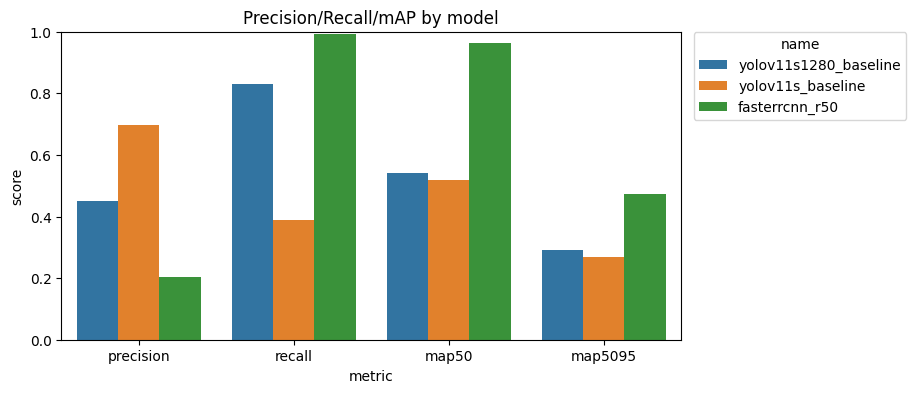

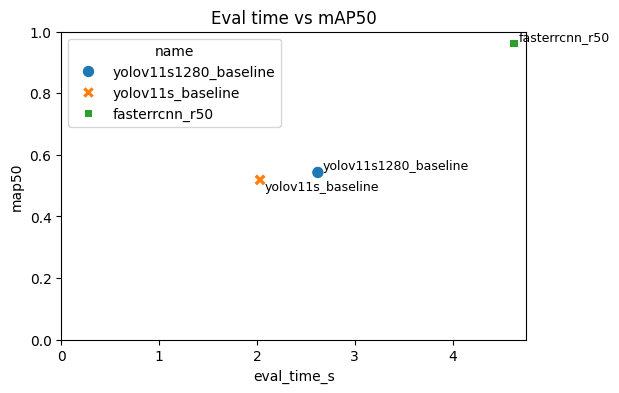

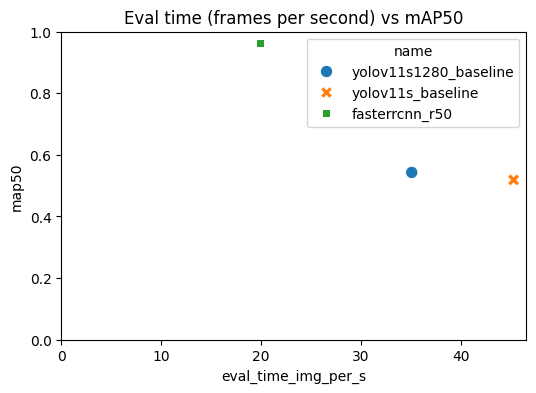

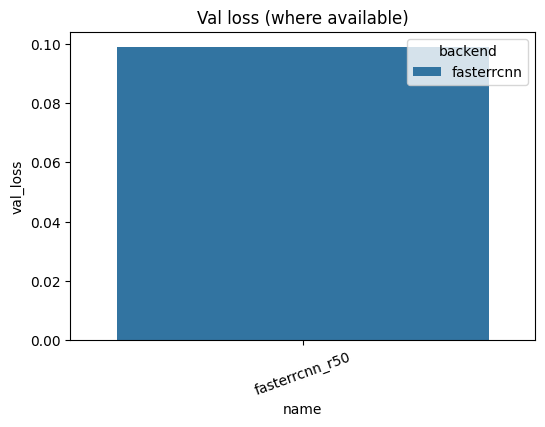

In [ ]:
plot_df = results_df.melt(id_vars=['name','backend'], value_vars=['precision','recall','map50','map5095'], var_name='metric', value_name='score')
plot_df = plot_df.dropna(subset=['score'])
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='metric', y='score', hue='name', ax=ax)
leg = ax.legend(title='name', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
leg.set_frame_on(True)          # optional styling
leg.set_title('name') 
ax.set_title('Precision/Recall/mAP by model')
ax.set_ylim(0, 1)
plt.show()

# # Broken when loading models
# fig, ax = plt.subplots(figsize=(6,4))
# sns.scatterplot(data=results_df, x='train_time_s', y='map50', hue='name', style='name', s=80, ax=ax)
# ax.set_title('Train time vs mAP50')
# plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=results_df, x='eval_time_s', y='map50', hue='name', style='name', s=80, ax=ax)
for _, row in results_df.iterrows():
    va = 'top' if row['name']=='yolov11s_baseline' else 'bottom'
    ax.text(row['eval_time_s']+0.05, row['map50'], row['name'], fontsize=9, ha='left', va=va)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=1)
ax.set_title('Eval time vs mAP50')
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=results_df, x='eval_time_img_per_s', y='map50', hue='name', style='name', s=80, ax=ax)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=1)
ax.set_title('Eval time (frames per second) vs mAP50')
plt.show()



## Per-prediction analysis (best YOLO model)
If no YOLO run with mAP exists, this section will be skipped.
Note: Road_poles_iPhone uses filelists (Train.txt/Validation.txt), not split folders; we load val via filelist below.


In [56]:
from ultralytics import YOLO
from torchvision.transforms import functional as F
from src.predictors.fasterrcnn import build_fasterrcnn
from src.data import load_split_dataframe

map_rows = results_df.dropna(subset=['map50', 'backend'])
if map_rows.empty:
    print('No results with mAP available; skipping per-prediction analysis.')
    pred_df = pd.DataFrame()
    sample_imgs = []
    pred_results = []
else:
    # Pick best by mAP50 regardless of backend
    best_row = map_rows.sort_values('map50', ascending=False).iloc[0]
    weights_path = Path(best_row['weights'])
    backend = best_row['backend']
    print(f'Using weights: {weights_path} ({backend})')

    dataset_key = getattr(paths, 'dataset_key', None) or infer_dataset_key(paths.dataset_root)
    val_df = load_split_dataframe('valid', dataset_key, paths.dataset_root)
    val_images = val_df['image_path'].dropna().unique().tolist()
    print(f'Validation images: {len(val_images)}')

    sample_imgs = val_images[: min(len(val_images), MAX_EVAL_IMAGES)]

    records = []
    if backend == 'yolo':
        model = YOLO(weights_path)
        pred_results = model(sample_imgs, conf=CONF_THRESH, verbose=False)
        for img_path, pred in zip(sample_imgs, pred_results):
            gt_rows = val_df[val_df['image_path'] == Path(img_path)]
            gt_boxes = [xywh_to_xyxy((r.cx, r.cy, r.w, r.h)) for r in gt_rows.itertuples()]
            if pred.boxes is None:
                continue
            pred_xywhn = pred.boxes.xywhn.cpu().numpy()
            pred_conf = pred.boxes.conf.cpu().numpy()
            pred_cls = pred.boxes.cls.cpu().numpy()
            for xywhn, conf, cls in zip(pred_xywhn, pred_conf, pred_cls):
                if conf < CONF_THRESH:
                    continue
                best_iou = 0.0
                hit = False
                for gt_box in gt_boxes:
                    i = iou(xywh_to_xyxy(xywhn), gt_box)
                    if i > best_iou:
                        best_iou = i
                    if i >= IOU_MATCH:
                        hit = True
                records.append({
                    'image_path': str(img_path),
                    'cx': xywhn[0],
                    'cy': xywhn[1],
                    'w': xywhn[2],
                    'h': xywhn[3],
                    'conf': conf,
                    'cls': int(cls),
                    'hit': hit,
                    'best_iou': best_iou,
                    'backend': backend,
                })
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = build_fasterrcnn(num_classes=2, weights='DEFAULT').to(device)
        state = torch.load(weights_path, map_location=device)
        model.load_state_dict(state)
        model.eval()
        pred_results = []
        for img_path in sample_imgs:
            with Image.open(img_path) as im:
                w, h = im.size
                tensor = F.to_tensor(im).to(device)
            with torch.no_grad():
                out = model([tensor])[0]
            pred_results.append(out)
            gt_rows = val_df[val_df['image_path'] == Path(img_path)]
            gt_boxes = [xywh_to_xyxy((r.cx, r.cy, r.w, r.h)) for r in gt_rows.itertuples()]
            boxes = out['boxes'].cpu().numpy() if 'boxes' in out else []
            scores = out['scores'].cpu().numpy() if 'scores' in out else []
            for (x1, y1, x2, y2), conf in zip(boxes, scores):
                if conf < CONF_THRESH:
                    continue
                # convert to normalized cx,cy,w,h
                bw = (x2 - x1) / w
                bh = (y2 - y1) / h
                cx = (x1 + x2) / (2 * w)
                cy = (y1 + y2) / (2 * h)
                best_iou = 0.0
                hit = False
                for gt_box in gt_boxes:
                    i = iou(xywh_to_xyxy((cx, cy, bw, bh)), gt_box)
                    if i > best_iou:
                        best_iou = i
                    if i >= IOU_MATCH:
                        hit = True
                records.append({
                    'image_path': str(img_path),
                    'cx': cx,
                    'cy': cy,
                    'w': bw,
                    'h': bh,
                    'conf': conf,
                    'cls': 0,
                    'hit': hit,
                    'best_iou': best_iou,
                    'backend': backend,
                })
    pred_df = pd.DataFrame(records)

pred_df.head()


Using weights: runs/fasterrcnn_r50_v1.pth (fasterrcnn)
Validation images: 92


,image_path,cx,cy,w,h,conf,cls,hit,best_iou,backend
0,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.648745,0.570739,0.009494,0.074423,0.944734,0,True,0.815033,fasterrcnn
1,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.242631,0.589962,0.005038,0.067017,0.937372,0,True,0.664409,fasterrcnn
2,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.842492,0.753414,0.006117,0.070327,0.823856,0,False,0.000000,fasterrcnn
3,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.241247,0.588520,0.003616,0.065818,0.435266,0,False,0.269648,fasterrcnn
4,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.244269,0.591127,0.004074,0.065641,0.336034,0,True,0.539066,fasterrcnn


In [75]:
# Add image properties
def compute_image_stats_for_preds(df):
    rows = []
    seen = {}
    for img_path in df['image_path'].dropna().unique():
        if img_path in seen:
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rows.append({
            'image_path': img_path,
            'brightness': float(gray.mean()),
            'contrast': float(gray.std()),
            'blur': float(cv2.Laplacian(gray, cv2.CV_64F).var()),
        })
        seen[img_path] = True
    return pd.DataFrame(rows)

img_stats = compute_image_stats_for_preds(pred_df)
pred_df['box_area'] = pred_df['w'] * pred_df['h']
pred_df['aspect'] = pred_df['w'] / (pred_df['h'] + 1e-9)
pred_df = pred_df.merge(img_stats, on='image_path', how='left')
display(pred_df.head())

,image_path,cx,cy,w,h,conf,cls,hit,best_iou,backend,box_area,aspect,brightness,contrast,blur
0,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.648745,0.570739,0.009494,0.074423,0.944734,0,True,0.815033,fasterrcnn,0.000707,0.127562,90.660984,32.374148,7.674637
1,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.242631,0.589962,0.005038,0.067017,0.937372,0,True,0.664409,fasterrcnn,0.000338,0.075176,90.660984,32.374148,7.674637
2,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.842492,0.753414,0.006117,0.070327,0.823856,0,False,0.000000,fasterrcnn,0.000430,0.086976,90.660984,32.374148,7.674637
3,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.241247,0.588520,0.003616,0.065818,0.435266,0,False,0.269648,fasterrcnn,0.000238,0.054935,90.660984,32.374148,7.674637
4,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.244269,0.591127,0.004074,0.065641,0.336034,0,True,0.539066,fasterrcnn,0.000267,0.062066,90.660984,32.374148,7.674637


In [76]:
if pred_df.empty:
    print('No prediction data to process.')
else:
    print('Collected', len(pred_df), 'predictions across', pred_df['image_path'].nunique(), 'images.')
    print(pred_df.head())


Collected 245 predictions across 92 images.
                                          image_path        cx        cy  \
0  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  0.648745  0.570739   
1  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  0.242631  0.589962   
2  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  0.842492  0.753414   
3  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  0.241247  0.588520   
4  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  0.244269  0.591127   

          w         h      conf  cls    hit  best_iou     backend  box_area  \
0  0.009494  0.074423  0.944734    0   True  0.815033  fasterrcnn  0.000707   
1  0.005038  0.067017  0.937372    0   True  0.664409  fasterrcnn  0.000338   
2  0.006117  0.070327  0.823856    0  False  0.000000  fasterrcnn  0.000430   
3  0.003616  0.065818  0.435266    0  False  0.269648  fasterrcnn  0.000238   
4  0.004074  0.065641  0.336034    0   True  0.539066  fasterrcnn  0.000267   

     aspect  brightness 

,hit,count,mean
0,False,107,0.523991
1,True,138,0.818992


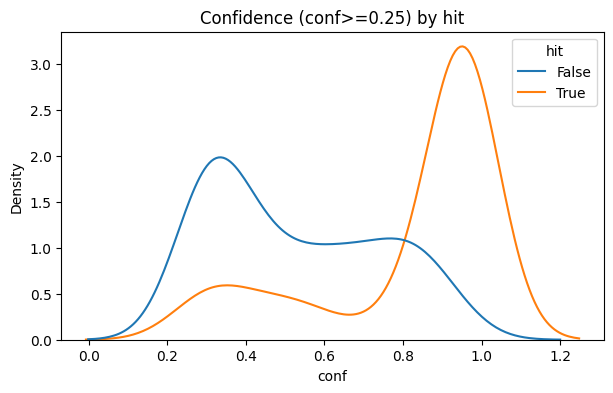

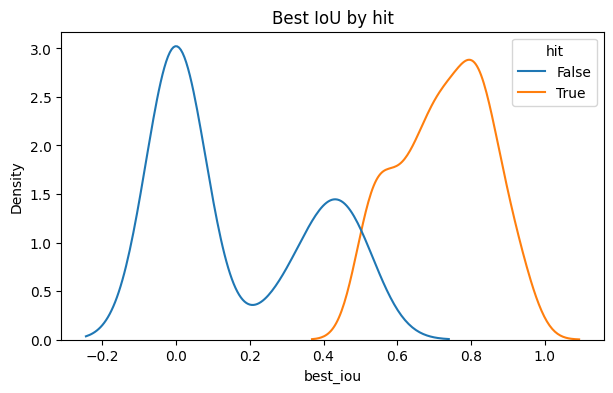

In [77]:
if pred_df.empty:
    print('No prediction data to summarize.')
else:
    summary = pred_df.groupby('hit')['conf'].agg(['count','mean']).reset_index()
    display(summary)

    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=pred_df, x='conf', hue='hit', common_norm=False, ax=ax)
    ax.set_title(f'Confidence (conf>={CONF_THRESH}) by hit')
    plt.show()

    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=pred_df, x='best_iou', hue='hit', common_norm=False, ax=ax)
    ax.set_title('Best IoU by hit')
    plt.show()


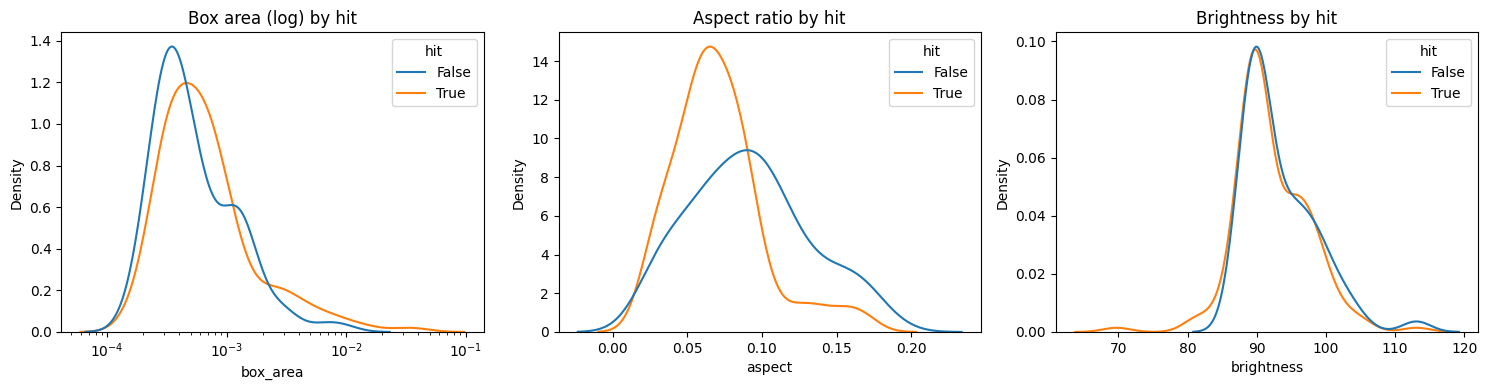

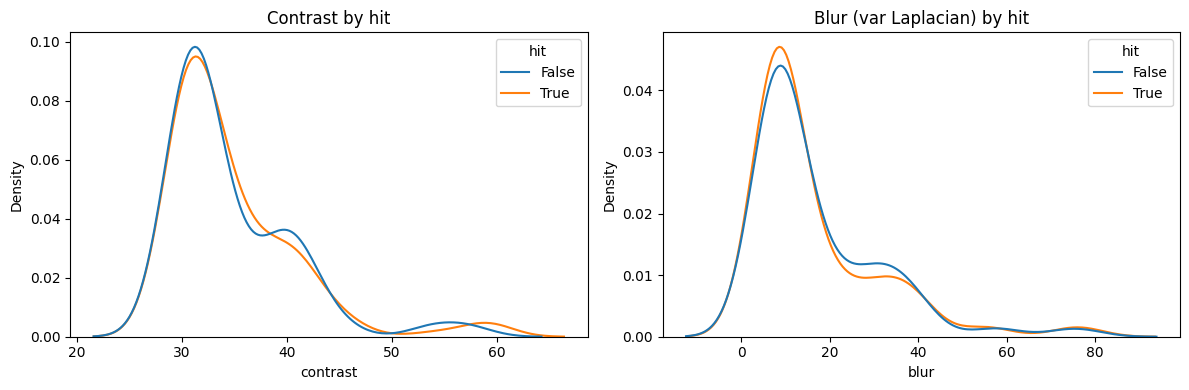

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.kdeplot(data=pred_df, x='box_area', hue='hit', common_norm=False, ax=axes[0], log_scale=True)
axes[0].set_title('Box area (log) by hit')
sns.kdeplot(data=pred_df, x='aspect', hue='hit', common_norm=False, ax=axes[1])
axes[1].set_title('Aspect ratio by hit')
sns.kdeplot(data=pred_df, x='brightness', hue='hit', common_norm=False, ax=axes[2])
axes[2].set_title('Brightness by hit')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.kdeplot(data=pred_df, x='contrast', hue='hit', common_norm=False, ax=axes[0])
axes[0].set_title('Contrast by hit')
sns.kdeplot(data=pred_df, x='blur', hue='hit', common_norm=False, ax=axes[1])
axes[1].set_title('Blur (var Laplacian) by hit')
plt.tight_layout()
plt.show()

### Visualize one TP and one FP (confidence shaded)


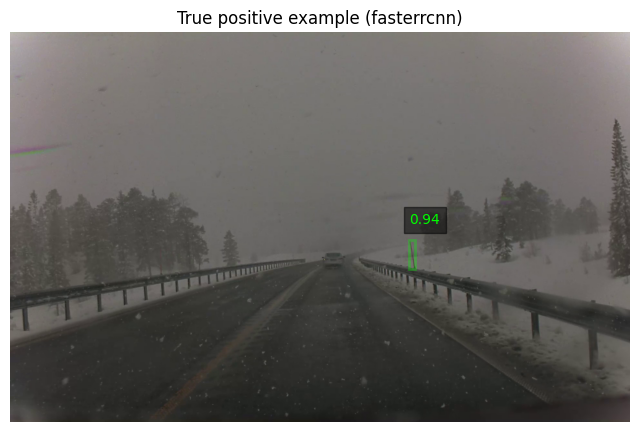

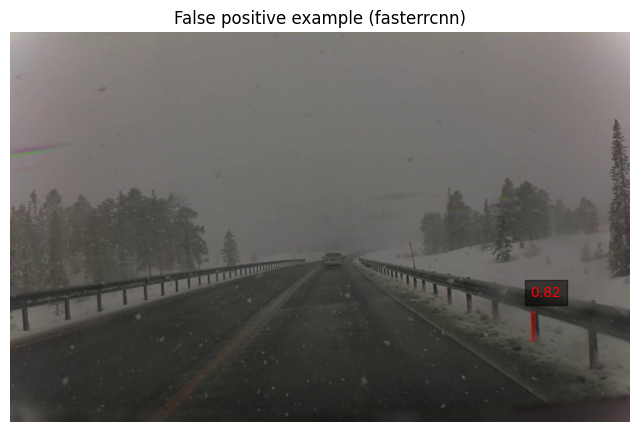

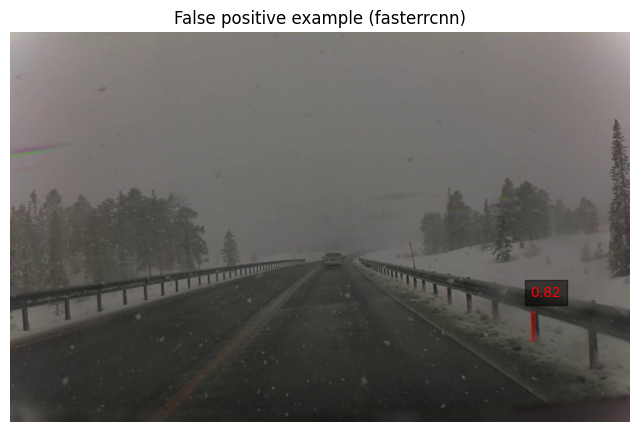

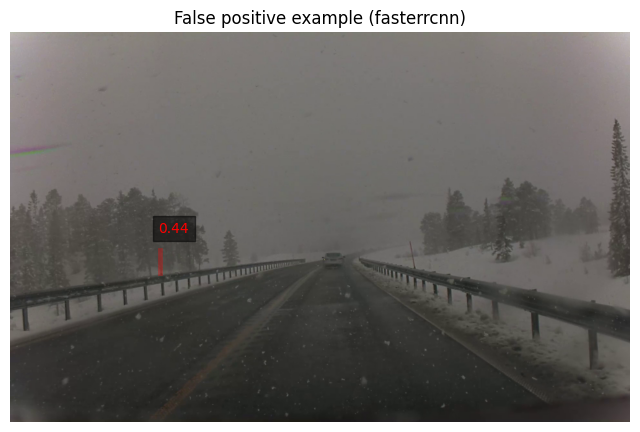

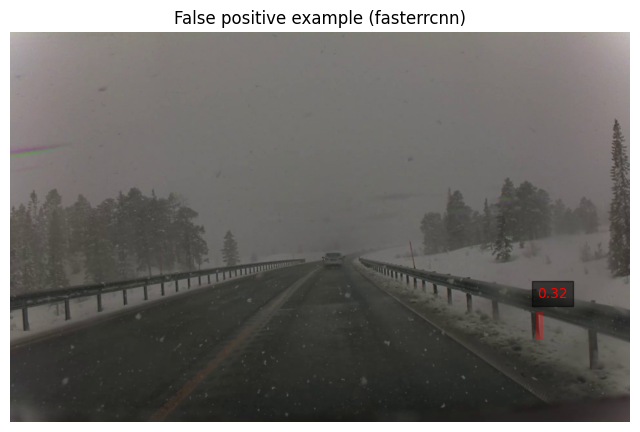

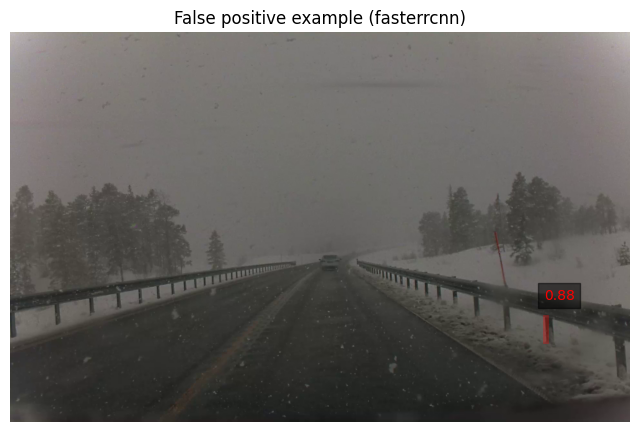

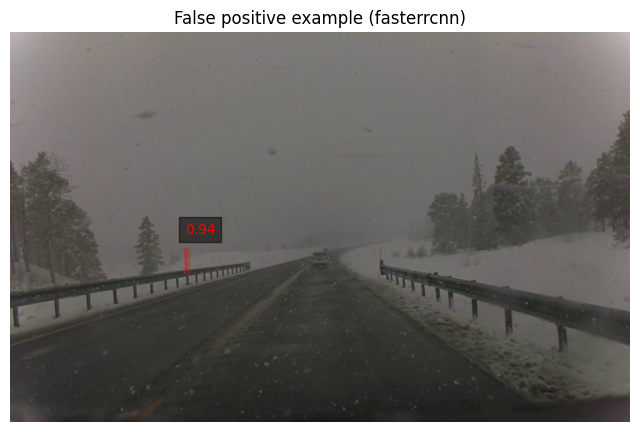

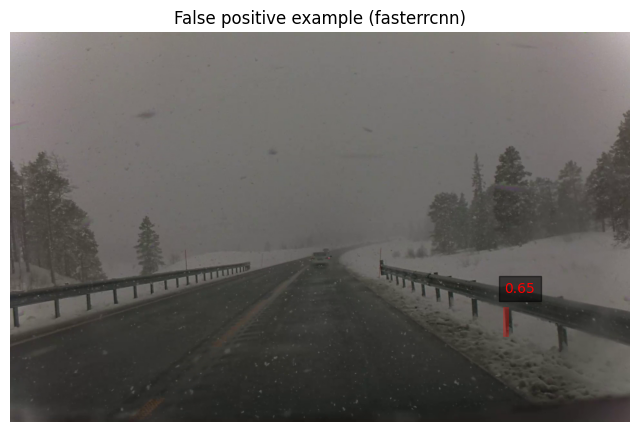

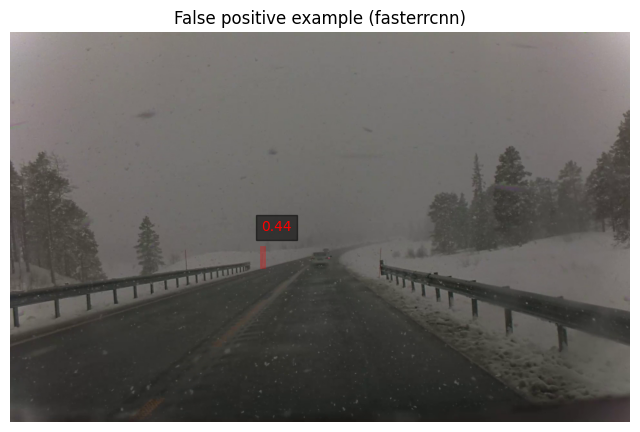

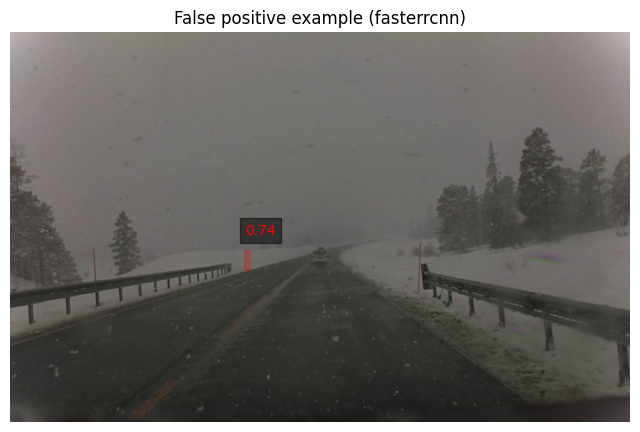

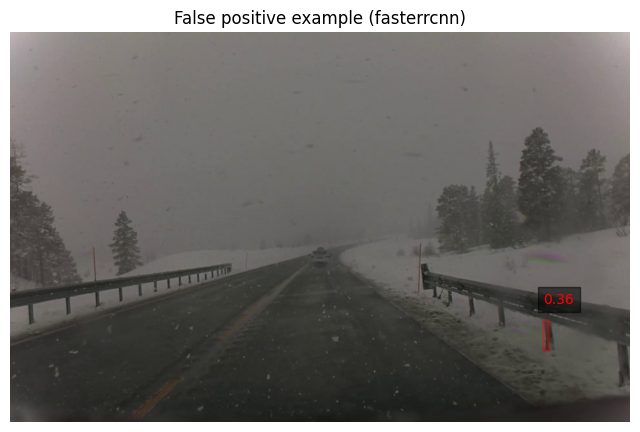

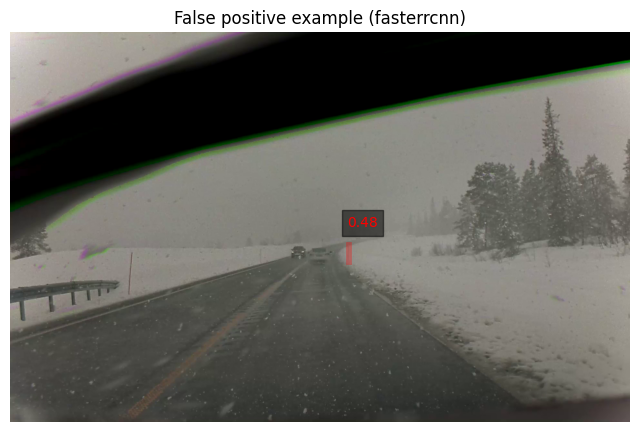

In [ ]:

tp_row = pred_df[pred_df['hit'] == True].head(1)
fp_row = pred_df[pred_df['hit'] == False].head(1)

def draw_box(row, title, edgecolor):
    img_path = row['image_path']
    img = plt.imread(img_path)
    h, w = img.shape[:2]
    cx, cy, bw, bh = row['cx'], row['cy'], row['w'], row['h']
    x1 = (cx - bw/2) * w
    y1 = (cy - bh/2) * h
    rect_w = bw * w
    rect_h = bh * h
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img)
    rect = plt.Rectangle((x1, y1), rect_w, rect_h, fill=False, edgecolor=edgecolor, linewidth=2, alpha=0.3)
    ax.add_patch(rect)
    ax.text(x1, y1-50, f"{row['conf']:.2f}", color=edgecolor, bbox=dict(facecolor='black', alpha=0.5))
    ax.set_title(f"{title} ({row['backend']})")
    ax.axis('off')
    plt.show()

if not tp_row.empty:
    draw_box(tp_row.iloc[0], 'True positive example', 'lime')
if not fp_row.empty:
    draw_box(fp_row.iloc[0], 'False positive example', 'red')

for i in range(10):
    draw_box(pred_df[pred_df['hit'] == False].iloc[i], 'False positive example', 'red')


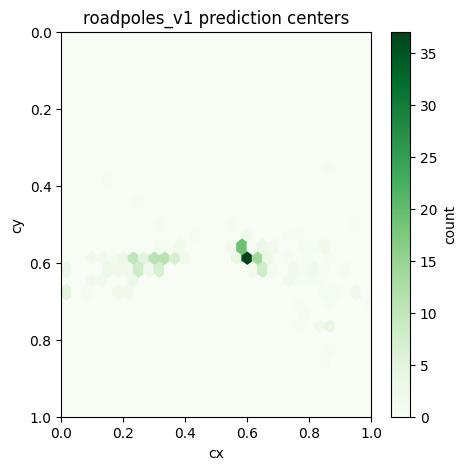

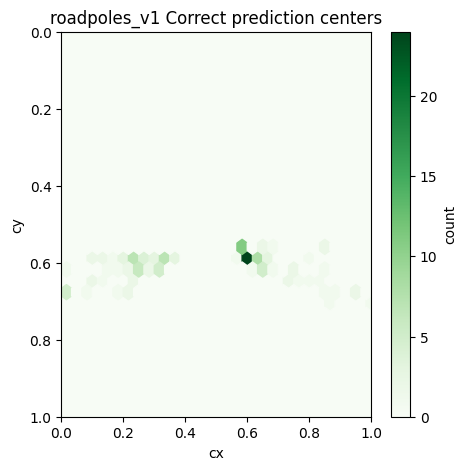

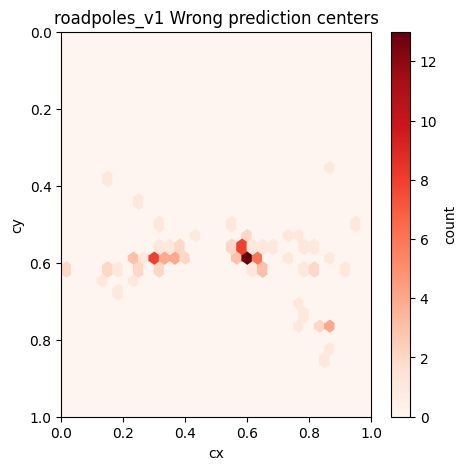

In [83]:
# Heatmap of predictions
def plot_center_heatmap(df, title, color):
    fig, ax = plt.subplots(figsize=(5, 5))
    hb = ax.hexbin(df["cx"], df["cy"], gridsize=30, cmap=color, extent=(0,1,0,1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("cx")
    ax.set_ylabel("cy")
    cb = fig.colorbar(hb, ax=ax)   # add colorbar
    cb.set_label("count")          # label the color scale
    plt.gca().invert_yaxis()
    plt.show()

plot_center_heatmap(pred_df, "roadpoles_v1 prediction centers", "Greens")
plot_center_heatmap(pred_df[pred_df["hit"] == True], "roadpoles_v1 Correct prediction centers", "Greens")
plot_center_heatmap(pred_df[pred_df["hit"] == False], "roadpoles_v1 Wrong prediction centers", "Reds")


### Notes
- `pred_df` is the consolidated "everything" table: predictions + confidence + IoU match.
- Adjust `CONF_THRESH`, `IOU_MATCH`, and `MAX_EVAL_IMAGES` up top for stricter/looser analysis.
